In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, bernoulli

In [2]:
class PricingEnvironment:
    def __init__(self, conversion_probability_1, conversion_probability_2, cost_1, cost_2):
        self.conversion_probability_1 = conversion_probability_1
        self.conversion_probability_2 = conversion_probability_2
        self.cost_1 = cost_1
        self.cost_2 = cost_2

    def round(self, p_t_1, n_t_1, p_t_2, n_t_2):
        d_t_1 = np.random.binomial(n_t_1, self.conversion_probability_1(p_t_1, p_t_2))

        r_t_1 = (p_t_1 - self.cost_1)*d_t_1

        d_t_2 = np.random.binomial(n_t_2, self.conversion_probability_2(p_t_1, p_t_2))
        r_t_2 = (p_t_2 - self.cost_2)*d_t_2

        return d_t_1, r_t_1, d_t_2, r_t_2

In [3]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale  # controls width of the Gaussian
        self.reg = reg  # regularization parameter to be added to the diagonal of the kernel matrix
        self.k_xx_inv = None  # stores inverse of kernel function
        self.x = np.zeros((1, 2)) # Initialize empty array for x
        self.y = np.zeros((1, 1))  # Initialize empty array for y

    def rbf_kernel_incr_inv(self, B, C, D):
        """_summary_

        Args:
            B : The kernel values between existing training data and new data points
            C : B transposed
            D : Regularization term

        Returns:
            inverse of the kernel matrix online
        """
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        """Radial Basis Function (RBF) kernel for bivariate data."""
        if a.size == 0 or b.size == 0:
            return np.eye(a.shape[0])  # Return a zero matrix if any input is empty
        a_ = a.reshape(a.shape[0], -1)  # Ensure a is 2D
        b_ = b.reshape(b.shape[0], -1)  # Ensure b is 2D
        output = np.zeros((a_.shape[0], b_.shape[0]))  # Initialize output matrix with correct shape
        for i in range(a_.shape[0]):
            for j in range(b_.shape[0]):
                output[i, j] = np.sum(np.power(a_[i] - b_[j], 2))
        return np.exp(-self.scale * output)

    def fit(self, x= np.zeros((1, 2)) , y=np.zeros((1, 1))):
        x, y = np.array(x), np.array(y)


        if self.k_xx_inv is None:
            self.x = x.reshape(x.shape[0], -1)  # Ensure x is 2D
            self.y = y.reshape(-1, 1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x.reshape(x.shape[0], -1)))  # Ensure x is 2D
            self.y = np.vstack((self.y, y.reshape(-1, 1)))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.eye(B.shape[1]) * self.reg)

        return self

    def predict(self, x_predict):
        if self.k_xx_inv is None:
            raise ValueError("The model has not been fitted yet.")

        x_predict = x_predict.reshape(x_predict.shape[0], -1)  # Ensure x_predict is 2D
        k = self.rbf_kernel(x_predict, self.x)
        k_ss = self.rbf_kernel(x_predict, x_predict)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [4]:
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms1 = np.linspace(0, 1, discretization)
        self.arms2 = np.linspace(0, 1, discretization)

        self.arms = np.array(np.meshgrid(self.arms1, self.arms2)).T.reshape(-1, 2)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.empty((0, 2))
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization*discretization)
        self.sigma_t = np.zeros(discretization*discretization)
        self.gamma = lambda t: np.log(t + 1)**2
        self.beta = lambda t: 1 + 0.5 * np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization* discretization)
        self.t = 0

    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms)

        ucbs = self.mu_t + (self.beta(self.t) * self.sigma_t)

        self.a_t = np.unravel_index(np.argmax(ucbs), ucbs.shape)

        return self.arms[self.a_t[0]]

    def update(self, r_t):
        arm_selected = self.arms[self.a_t[0]]

        self.N_pulls[self.a_t[0]] += 1
        #self.action_hist = np.vstack((self.action_hist, arm_selected))
        #self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(arm_selected.reshape(1, -1), np.array([[r_t]]))
        self.t += 1

In [5]:
def discretize(T):
    epsilon = T**(-0.33)
    K = int(1/epsilon)
    return K

def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

In [18]:
n_customers = 100
cost = 0.1
min_price, max_price = 0, 1
T= 200

K=20
prices = np.linspace(min_price, max_price, K)

 # reward function
reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers)

#profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
#best_price_index = np.argmax(profit_curve)
#best_price = prices[best_price_index]
#expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

In [19]:
cp1 = lambda p1, p2: 1-p1/1
cp2 = lambda p1, p2: np.minimum(np.maximum(0, 1 + 0.5*p1 - p2), 1)

In [20]:
gp_agent = GPUCBAgent(T, discretization=K)
env = PricingEnvironment(conversion_probability_1=cp1, conversion_probability_2=cp2, cost_1=cost, cost_2=cost)
gp_agent_rewards = np.array([])
gp_agent_arms = np.array([])
for t in range(T):

    p_t = gp_agent.pull_arm()

    d_t_1, r_t_1, d_t_2, r_t_2 = env.round(p_t[0], n_customers, p_t[1], n_customers)

    r_t= r_t_1 + r_t_2

    gp_agent.update(r_t/n_customers)
    gp_agent_rewards = np.append(gp_agent_rewards, r_t)
    gp_agent_arms = np.append(gp_agent_arms, p_t)

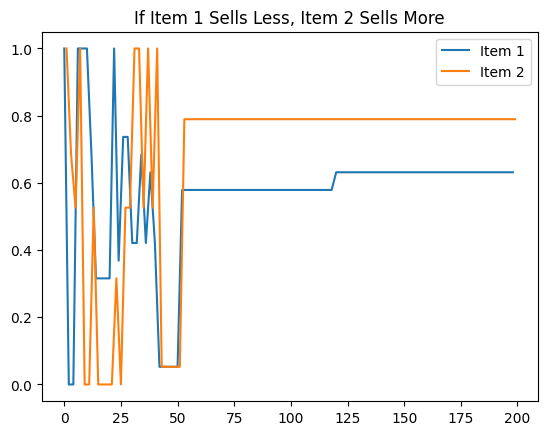

In [23]:
plt.plot(range(0,200,2), gp_agent_arms[range(0,200,2)], label='Item 1')
plt.plot(range(1,200,2), gp_agent_arms[range(1,200,2)], label='Item 2')
plt.title('If Item 1 Sells Less, Item 2 Sells More')
plt.legend()